# Cross-Validation

In [53]:
library(caret)
set.seed(1)
draw.data <- function(n) {
    x <- rnorm(n)
    y <- 2+x-2*x^2 + rnorm(n)
    return(data.frame(x=x,y=y))
}
data <- draw.data(150)
true.test.data <- draw.data(5000)

## Validation Set
We begin by using the validation set approach to estimate the test statistics for various linear models.

First, split the data into a training and a validation set:

In [67]:
trainIdx <- createDataPartition(data$y,p=0.8,list=FALSE)
training.set <- data[trainIdx,]
validation.set <- data[-trainIdx,]

In [68]:
estimate.models <- function(training.set) {
    models <- list()
    models$lm1 <- lm(y~poly(x,1),data=training.set)
    models$lm2 <- lm(y~poly(x,2),data=training.set)
    models$lm3 <- lm(y~poly(x,3),data=training.set)
    models$lm4 <- lm(y~poly(x,4),data=training.set)
    models$lm5 <- lm(y~poly(x,5),data=training.set)
    return(models)
}
estimate.mse <- function(model,data.set) {
    mean((predict(model,newdata=data.set)-data.set$y)^2)
}

In [69]:
models <- estimate.models(training.set)

In [70]:
testMSE.VS <- numeric(length(models))
true.testMSE <- numeric(length(models))
for(i in seq_along(models)) {
    model <- models[[i]]
    testMSE.VS[i] <- estimate.mse(model,validation.set)
    true.testMSE[i] <- estimate.mse(model,true.test.data)
}

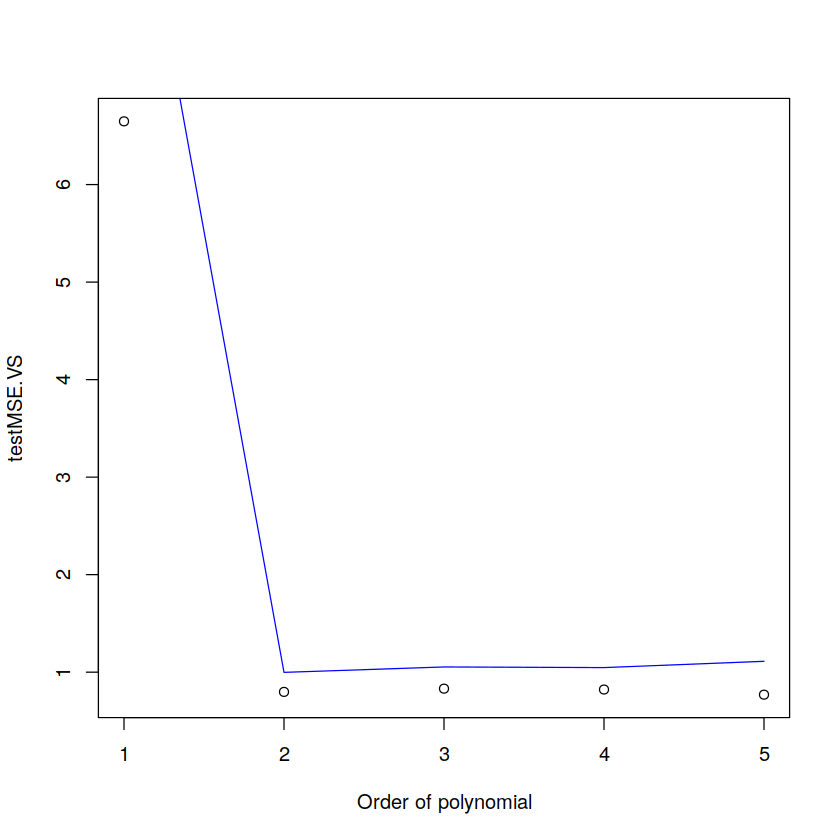

In [71]:
plot(testMSE.VS,xlab="Order of polynomial")
lines(true.testMSE,col="blue")

## Leave-One-Out Cross-validation

In [83]:
# rows are observations 1...n, columns are the models (1,2,3,4,5)
testMSE.LOOCV <- matrix(0,nrow=nrow(data),ncol=length(models))
for(i in seq(nrow(data))){
    training.data <- data[-i,]
    testing.data <- data[i,]
    models <- estimate.models(training.data)
    for(j in seq_along(models)) {
        model <- models[[j]]
        testMSE.LOOCV[i,j] <- estimate.mse(model,testing.data)
    }
}

In [84]:
testMSE.LOOCV <- colMeans(testMSE.LOOCV)
testMSE.LOOCV

[1] 6.287666 1.076810 1.086111 1.111598 1.102538

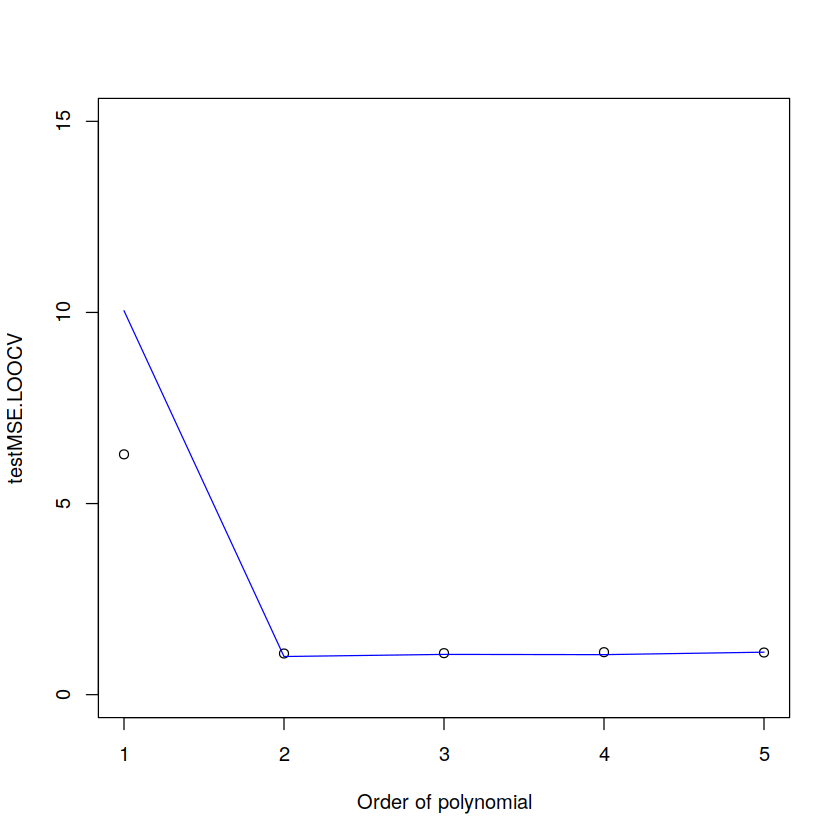

In [78]:
plot(testMSE.LOOCV,ylim=c(0,15),xlab="Order of polynomial")
lines(true.testMSE,col="blue")

In [79]:
which.min(testMSE.LOOCV)

[1] 2

## $k$-fold Cross-validation
With $k=10$

In [109]:
folds <- createFolds(data$y,10)
#rows are folds 1...10, columns are the models 1....5
testMSE.10fold <- matrix(0,nrow=length(folds),ncol=length(models))
for(i in seq_along(folds)) {
    training.data <- data[-folds[[i]],]
    testing.data <- data[folds[[i]],]
    models <- estimate.models(training.data)
    for(j in seq_along(models)) {
        testMSE.10fold[i,j] <- estimate.mse(models[[j]],testing.data)
    }
}
testMSE.10fold <- colMeans(testMSE.10fold)

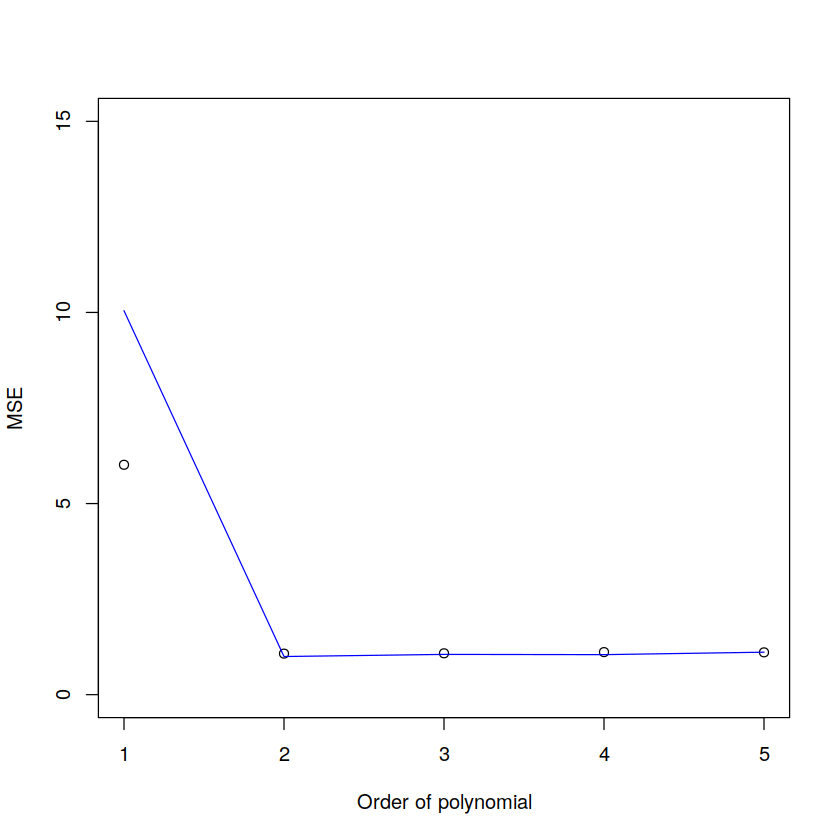

In [110]:
plot(testMSE.10fold,ylim=c(0,15),xlab="Order of polynomial",ylab="MSE")
lines(true.testMSE,col="blue")

In [111]:
which.min(testMSE.10fold)

[1] 2

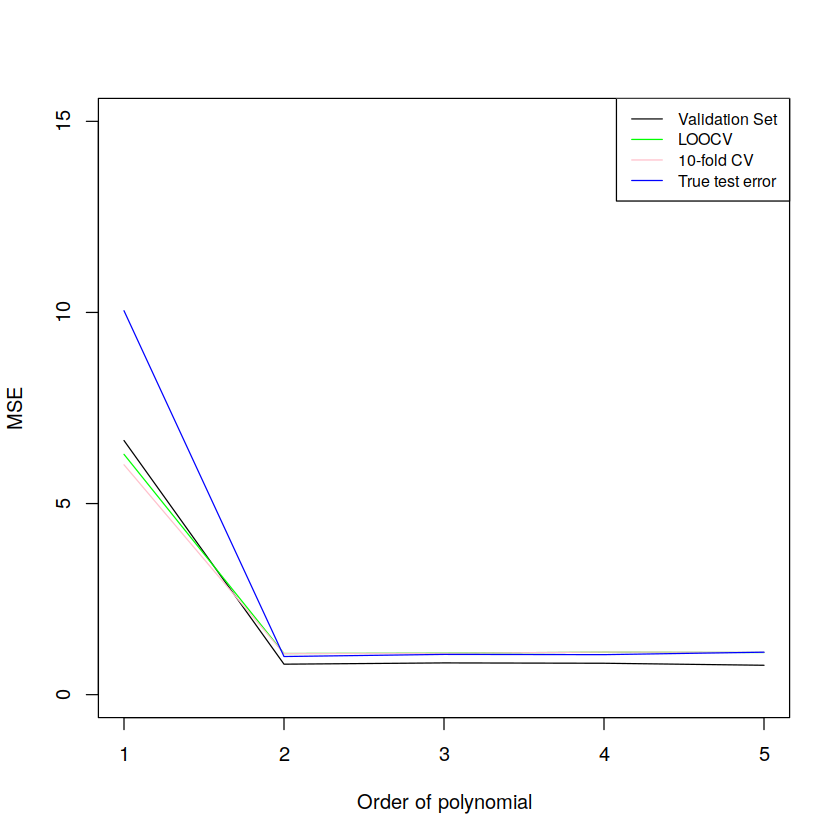

In [113]:
plot(testMSE.VS,ylim=c(0,15),xlab="Order of polynomial",ylab="MSE",type='l')
lines(testMSE.LOOCV,col="green")
lines(testMSE.10fold,col="pink")
lines(true.testMSE,col="blue")
legend("topright",legend=c("Validation Set","LOOCV","10-fold CV","True test error"),col=c("black","green","pink","blue"),cex=0.8,lty=1)